In [1]:
from google.colab import files
uploaded = files.upload()

Saving CIPLA.csv to CIPLA.csv


In [47]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model


# Reading data using parse date
As it is timeseries data so we have to read the data by parsing date means making data column as index.

In [48]:
df_final = pd.read_csv("CIPLA.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

In [49]:
df_final.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,CIPLA,EQ,1349.40,1410.0,1457.35,1380.05,1457.35,1457.35,1441.36,21060,3.035496e+12,NaN,NaN,NaN
2000-01-04,CIPLA,EQ,1457.35,1537.0,1537.00,1430.00,1466.05,1465.25,1460.43,30215,4.412698e+12,NaN,NaN,NaN
2000-01-05,CIPLA,EQ,1465.25,1474.0,1474.00,1365.00,1441.00,1435.05,1428.11,33799,4.826872e+12,NaN,NaN,NaN
2000-01-06,CIPLA,EQ,1435.05,1434.0,1435.00,1349.00,1365.00,1355.85,1390.55,33083,4.600356e+12,NaN,NaN,NaN
2000-01-07,CIPLA,EQ,1355.85,1370.0,1389.90,1247.40,1247.40,1247.55,1267.49,66536,8.433351e+12,NaN,NaN,NaN


In [50]:

df_final.shape

(5306, 14)

In [51]:
df_final.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.792000e+03,4792.000000
mean,540.503798,541.457755,549.587693,532.143583,540.472588,540.421052,540.931589,1.550071e+06,7.841696e+13,44967.250407,7.408486e+05,0.509209
std,289.319810,289.955959,295.087710,283.868905,289.158087,289.151156,289.411215,2.317962e+06,1.620908e+14,43776.047324,7.339493e+05,0.154639
min,160.100000,150.550000,169.450000,145.000000,152.000000,160.100000,158.140000,5.050000e+02,5.400606e+10,613.000000,2.013000e+03,0.069300
25%,309.025000,309.962500,312.750000,305.350000,309.000000,309.025000,309.290000,3.790408e+05,1.447839e+13,21724.000000,2.831312e+05,0.404575
50%,473.850000,474.625000,479.950000,468.875000,473.525000,473.850000,475.215000,1.047786e+06,3.725861e+13,32967.000000,5.787145e+05,0.516650
75%,681.937500,683.225000,691.787500,671.675000,681.937500,681.937500,682.035000,1.815542e+06,7.848478e+13,50869.500000,9.761000e+05,0.615125
max,1465.250000,1537.000000,1537.000000,1430.000000,1466.050000,1465.250000,1460.430000,5.689556e+07,4.498902e+15,603361.000000,1.081558e+07,0.994500


In [52]:
df_final.isnull().values.any()

True

In [53]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Close'])
display(test.head())

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,CIPLA,EQ,1349.40,1410.0,1457.35,1380.05,1457.35,1457.35,1441.36,21060,3.035496e+12,NaN,NaN,NaN
2000-01-04,CIPLA,EQ,1457.35,1537.0,1537.00,1430.00,1466.05,1465.25,1460.43,30215,4.412698e+12,NaN,NaN,NaN
2000-01-05,CIPLA,EQ,1465.25,1474.0,1474.00,1365.00,1441.00,1435.05,1428.11,33799,4.826872e+12,NaN,NaN,NaN
2000-01-06,CIPLA,EQ,1435.05,1434.0,1435.00,1349.00,1365.00,1355.85,1390.55,33083,4.600356e+12,NaN,NaN,NaN
2000-01-07,CIPLA,EQ,1355.85,1370.0,1389.90,1247.40,1247.40,1247.55,1267.49,66536,8.433351e+12,NaN,NaN,NaN


In [54]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

# Normalizing the data

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2000-01-03,0.908399,0.941757,0.961128,0.000361
2000-01-04,1.000000,1.000000,1.000000,0.000522
2000-01-05,0.954560,0.953932,0.949416,0.000585
2000-01-06,0.925710,0.925414,0.936965,0.000573
2000-01-07,0.879548,0.892435,0.857899,0.001161


In [56]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
2000-01-03,0.908399,0.941757,0.961128,0.000361
2000-01-04,1.000000,1.000000,1.000000,0.000522
2000-01-05,0.954560,0.953932,0.949416,0.000585
2000-01-06,0.925710,0.925414,0.936965,0.000573
2000-01-07,0.879548,0.892435,0.857899,0.001161


Shape of features :  (5306, 4)
Shape of target :  (5306, 1)


,Open,High,Low,Volume
Date,,,,
2021-04-23,0.572541,0.572849,0.605253,0.140119
2021-04-26,0.566230,0.563453,0.589222,0.180247
2021-04-27,0.549930,0.548463,0.588327,0.099632
2021-04-28,0.550903,0.547366,0.589844,0.127436
2021-04-29,0.549172,0.546927,0.590661,0.087048


,Close
Date,
2021-04-23,905.40
2021-04-26,912.40
2021-04-27,910.20
2021-04-28,906.50
2021-04-29,910.35



 -----After process------ 

Shape of features :  (5216, 4)
Shape of target :  (5216, 1)


,Close
Date,
2020-12-10,755.85
2020-12-11,789.30
2020-12-14,781.65
2020-12-15,786.80
2020-12-16,783.20


# Train test Split using Timeseriessplit

In [57]:
ts_split= TimeSeriesSplit(n_splits=5)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [58]:

X_train.shape

(4347, 4)

In [59]:
X_test.shape

(869, 4)

In [60]:
y_train.shape

(4347,)

In [61]:
y_test.shape

(869,)

In [62]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

# Benchmark Model

RMSE:  34.962776755100066
R2 score:  0.34769564626063665


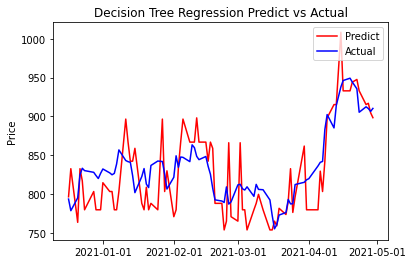

In [63]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

# Process the data for Bidirectional LSTM

In [64]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Model building : Bidirectional LSTM

In [65]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM, Bidirectional
K.clear_session()
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False), input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
544/544 [==============================] - 3s 2ms/step - loss: 373093.4688
Epoch 2/200
544/544 [==============================] - 1s 2ms/step - loss: 340539.0000
Epoch 3/200
544/544 [==============================] - 1s 2ms/step - loss: 287667.2500
Epoch 4/200
544/544 [==============================] - 1s 2ms/step - loss: 226588.7656
Epoch 5/200
544/544 [==============================] - 1s 2ms/step - loss: 167569.1094
Epoch 6/200
544/544 [==============================] - 1s 2ms/step - loss: 116686.5703
Epoch 7/200
544/544 [==============================] - 1s 2ms/step - loss: 77169.7812
Epoch 8/200
544/544 [==============================] - 1s 2ms/step - loss: 49602.7539
Epoch 9/200
544/544 [==============================] - 1s 3ms/step - loss: 32306.3418
Epoch 10/200
544/544 [==============================] - 1s 2ms/step - loss: 22144.0176
Epoch 11/200
544/544 [==============================] - 1s 2ms/step - loss: 15732.6504
Epoch 12/200
544/544 [========================

# Evaluation of Model

In [66]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)


The R2 score on the Train set is:	0.994
The R2 score on the Test set is:	0.980


## Predictions made by LSTM

In [67]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

869/869 [==============================] - 2s 1ms/step - loss: 159.9248


In [68]:
print('LSTM: %f'%score_lstm)

LSTM: 159.924774


In [69]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

# LSTM's Prediction Visual

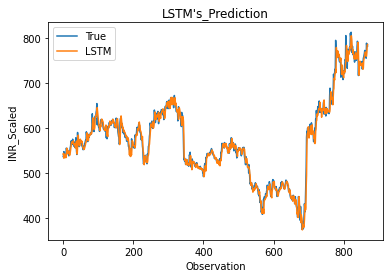

In [70]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()
